In [1]:
# !pip install yfinance
import yfinance as yf
import investpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import datetime
import pandas_datareader as pdr
import quandl


%run keys.ipynb



from sklearn.preprocessing import MinMaxScaler, StandardScaler

###  Making it possible to pull data from FRED and Quandl

In [2]:
data_source = 'fred'
start = datetime.datetime (1960, 1, 1)      #  (2005, 5, 1)
end = datetime.datetime (2030, 12, 1)



# ISM-PMI  quandl.get("ISM/MAN_PMI")
ism_pmi = quandl.get("ISm/MAN_PMI", authtoken=quandl.ApiConfig.api_key)
ism_pmi.columns = ['_raw']


# Reading in the dataset - Durable Goods - creating new features
DurableGoods = pdr.DataReader('DGORDER', data_source, start, end)
DurableGoods.columns = ['_raw']

In [3]:
ism_pmi.shape

(883, 1)

###  Helper Functions

In [4]:
"""
This function averages 2 periods in a time series. 
Alternatively, one could use --> df.rolling(2).mean()
"""
def smoothingMA2(df):
    data = df.copy()
    df1 = (data + data.shift(1)) / 2
    return df1



"""
Calculates the First Difference of the 
2nd Derivative (Rate of Change/Acceleration).
""" 
def RoC(df, n):   
    df1 = df.copy()
    df1 = (np.log(df1).diff(n))
    df1 = df1 - (df1.shift(1))
    df1 = df1 * 100
    return df1


"""
Only use this roc function after getting the Year over Year 
percentage change because this function does not calculate the  
log difference or np.log().diff().
"""
def roc(df, n):
    data = df.copy()
    df1 = (data - data.shift(n))
    return df1


"""
Plots line graphs 
"""
def plotLines(df, i:int, title, w_name, x_name, y_name, z_name):
# def plotLines(df, i:int, title, x_name, y_name):
# def plotLines(df, i:int, title, w_name, y_name, z_name):
    # Controls amount of data to plot
    df =  df[500:]
    
    w = df[w_name]
    x = df[x_name]
    y = df[y_name]
    z = df[z_name]
    
    # Plot style
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(30,15)) # chart 2:1
    
    # Sets Title of Plot
    ax.set_title(title, fontsize=32, fontweight='bold', x=.242, y=1.07)
    
    # Line plot these columns: column1, column2
    plt.plot(w.index, w, color='black', linewidth=3, label="Price-Daily")
    plt.plot(x.index, x, color='orange', linewidth=3, label="Rolling 7D Mean")
    plt.plot(y.index, y, color='red', linewidth=3, label="UpperBound Dynamic R/S")
    plt.plot(z.index, z, color='green', linewidth=3, label="LowerBound Dynamic R/S")
    # Adds a legened
    plt.legend(loc="upper left")
    
    # Turn off the spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()
    
    
"""
Creates the features involved in making the plots and calculations.  
This allows one to simply apply the function to multiple dataframes 
when the same analysis is needed.
"""
def createFeatures(df, prefix:str):
    df['_%mom'] = df.iloc[:,0].pct_change() * 100
    df['_%qoq'] = df.iloc[:,0].pct_change(3) * 100
    df['_%yoy'] = df.iloc[:,0].pct_change(12) * 100
    
    df['_smoothingMA'] = (df['_%yoy'] + df['_%yoy'].shift(1) + df['_%yoy'].shift(2) + df['_%yoy'].shift(3)) / 4
    df['_rocMA'] = roc(df['_smoothingMA'], 1)
    df['_smoothedRoC'] = smoothingMA2(df['_rocMA'])
    
    df = df.add_prefix(prefix)
    df.dropna(inplace=True)

    return df


"""
Applying Standard Scaler and MinMaxScaler-->(Experimental)
Standard Scaler was used going forward in this notebook (Not MinMaxScaler).
"""

def standardScaler(df, scaled_df_name:str):
    st_scaler = StandardScaler()
    scaled_df= st_scaler.fit_transform(df)
    scaled_df= pd.DataFrame(scaled_df, columns=df.columns)
    scaled_df.dropna(inplace=True)
    scaled_df.reset_index(inplace=True)
#     scaled_df = scaled_df.add_prefix(prefix)
    scaled_df_name = scaled_df.drop(['index'], axis=1)
    return scaled_df_name

In [5]:
sp_df = pdr.get_data_yahoo(
    "SPY",
    start='2012-01-01', 
    end='2030-12-01')
sp_df = sp_df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)

spy = createFeatures(sp_df, "SPY")
# spy.tail()

energy_df = investpy.get_etf_historical_data(
    etf='Energy Select Sector SPDR',
    country='United States',
    from_date='01/01/2012',
    to_date='12/01/2030', 
    interval='Daily')
energy_df = energy_df.drop(['Open', 'High', 'Low', 'Currency', 'Exchange'], axis=1) 

energy = createFeatures(energy_df, "ENGY")

In [6]:
energy.tail()

,ENGYClose,ENGYVolume,ENGY_%mom,ENGY_%qoq,ENGY_%yoy,ENGY_smoothingMA,ENGY_rocMA,ENGY_smoothedRoC
Date,,,,,,,,
2021-07-29,50.19,21897010,0.965600,0.945294,-4.162689,-5.169238,0.654813,0.597176
2021-07-30,49.39,24800340,-1.593943,0.263906,-2.794725,-4.887243,0.281995,0.468404
2021-08-02,49.02,28905400,-0.749140,-1.388051,-2.155689,-3.727963,1.159280,0.720638
2021-08-03,49.86,32151044,1.713586,-0.657501,2.423993,-1.672277,2.055686,1.607483
2021-08-04,48.51,32259056,-2.707581,-1.781737,3.300681,0.193565,1.865842,1.960764


In [7]:
def punctRescaledRange(df, column, window=16):
    
    df = df.copy()
#     window=18

    df['rollingList'] = [window.to_list() for window in df[column].rolling(window=window)]
    df['rollingMean'] = df[column].rolling(window=window).mean()

    all = []
    # Subtracts rilling mean from each element in rolling list of length=window
    zipped = zip(df['rollingList'], df['rollingMean'])
    for x, y in zipped:
        all.append([round(x[i]-y, 2) for i in range(len(x))])

    df['meanAdjustedSeries'] = all

    x = np.array(df['meanAdjustedSeries'])

    ls = []

    for item in x:
        ls.append(np.cumsum(item).round(2))

    df['rescaledRange'] = ls

    ls1 = []
    x1 = np.array(df['rescaledRange'])
    for item in x1:
        ls1.append(np.std(item).round(2))

    df['std'] = ls1


    df['upperBound'] = df['rollingMean'] + df['std'] 
    df['lowerBound'] = df['rollingMean'] - df['std']

    return df

In [8]:
spy_new = punctRescaledRange(spy, 'SPYClose')
energy_new =punctRescaledRange(energy, 'ENGYClose')

In [9]:
energy_new.tail(12)

,ENGYClose,ENGYVolume,ENGY_%mom,ENGY_%qoq,ENGY_%yoy,ENGY_smoothingMA,ENGY_rocMA,ENGY_smoothedRoC,rollingList,rollingMean,meanAdjustedSeries,rescaledRange,std,upperBound,lowerBound
Date,,,,,,,,,,,,,,,
2021-07-20,47.59,41671024,1.341567,-5.009980,-12.982264,-11.674752,-1.825481,-2.482185,"[54.81, 54.69, 54.69, 54.69, 54.69, 52.91, 52....",52.025625,"[2.78, 2.66, 2.66, 2.66, 2.66, 0.88, 0.02, -0....","[2.78, 5.44, 8.1, 10.76, 13.42, 14.3, 14.32, 1...",4.93,56.955625,47.095625
2021-07-21,49.25,41021320,3.488128,1.170912,-9.946974,-12.013165,-0.338413,-1.081947,"[54.69, 54.69, 54.69, 54.69, 52.91, 52.05, 51....",51.678125,"[3.01, 3.01, 3.01, 3.01, 1.23, 0.37, 0.07, 1.1...","[3.01, 6.02, 9.03, 12.04, 13.27, 13.64, 13.71,...",5.19,56.868125,46.488125
2021-07-22,48.70,23635028,-1.116751,3.705281,-7.956908,-11.255089,0.758076,0.209832,"[54.69, 54.69, 54.69, 52.91, 52.05, 51.75, 52....",51.303750,"[3.39, 3.39, 3.39, 1.61, 0.75, 0.45, 1.55, 1.4...","[3.39, 6.78, 10.17, 11.78, 12.53, 12.98, 14.53...",5.24,56.543750,46.063750
2021-07-23,48.52,23475940,-0.369610,1.954192,-6.781940,-9.417021,1.838068,1.298072,"[54.69, 54.69, 52.91, 52.05, 51.75, 52.85, 52....",50.918125,"[3.77, 3.77, 1.99, 1.13, 0.83, 1.93, 1.85, 1.4...","[3.77, 7.54, 9.53, 10.66, 11.49, 13.42, 15.27,...",5.15,56.068125,45.768125
2021-07-26,49.72,23633104,2.473207,0.954315,-3.922705,-7.152132,2.264890,2.051479,"[54.69, 52.91, 52.05, 51.75, 52.85, 52.77, 52....",50.607500,"[4.08, 2.3, 1.44, 1.14, 2.24, 2.16, 1.76, 0.2,...","[4.08, 6.38, 7.82, 8.96, 11.2, 13.36, 15.12, 1...",4.91,55.517500,45.697500
2021-07-27,49.26,23444182,-0.925181,1.149897,-6.792810,-6.363591,0.788541,1.526715,"[52.91, 52.05, 51.75, 52.85, 52.77, 52.37, 50....",50.268125,"[2.64, 1.78, 1.48, 2.58, 2.5, 2.1, 0.54, -0.17...","[2.64, 4.42, 5.9, 8.48, 10.98, 13.08, 13.62, 1...",4.53,54.798125,45.738125
2021-07-28,49.71,19584640,0.913520,2.452597,-5.798749,-5.824051,0.539540,0.664040,"[52.05, 51.75, 52.85, 52.77, 52.37, 50.81, 50....",50.068125,"[1.98, 1.68, 2.78, 2.7, 2.3, 0.74, 0.03, -1.39...","[1.98, 3.66, 6.44, 9.14, 11.44, 12.18, 12.21, ...",4.24,54.308125,45.828125
2021-07-29,50.19,21897010,0.965600,0.945294,-4.162689,-5.169238,0.654813,0.597176,"[51.75, 52.85, 52.77, 52.37, 50.81, 50.1, 48.6...",49.951875,"[1.8, 2.9, 2.82, 2.42, 0.86, 0.15, -1.27, -2.9...","[1.8, 4.7, 7.52, 9.94, 10.8, 10.95, 9.68, 6.69...",3.98,53.931875,45.971875
2021-07-30,49.39,24800340,-1.593943,0.263906,-2.794725,-4.887243,0.281995,0.468404,"[52.85, 52.77, 52.37, 50.81, 50.1, 48.68, 46.9...",49.804375,"[3.05, 2.97, 2.57, 1.01, 0.3, -1.12, -2.84, -2...","[3.05, 6.02, 8.59, 9.6, 9.9, 8.78, 5.94, 3.73,...",3.55,53.354375,46.254375


In [10]:
spy_new.tail(3)

,SPYClose,SPYVolume,SPY_%mom,SPY_%qoq,SPY_%yoy,SPY_smoothingMA,SPY_rocMA,SPY_smoothedRoC,rollingList,rollingMean,meanAdjustedSeries,rescaledRange,std,upperBound,lowerBound
Date,,,,,,,,,,,,,,,
2021-08-02,437.589996,58783300.0,-0.209804,-0.282567,0.653248,0.683909,-0.037024,-0.246444,"[437.0799865722656, 435.5899963378906, 436.239...",436.036871,"[1.04, -0.45, 0.2, -1.29, -4.7, -11.07, -4.98,...","[1.04, 0.59, 0.79, -0.5, -5.2, -16.27, -21.25,...",8.93,444.966871,427.106871
2021-08-03,441.149994,57987900.0,0.813546,0.113469,2.274307,1.152390,0.468481,0.215728,"[435.5899963378906, 436.239990234375, 434.75, ...",436.291246,"[-0.7, -0.05, -1.54, -4.95, -11.32, -5.23, -1....","[-0.7, -0.75, -2.29, -7.24, -18.56, -23.79, -2...",9.18,445.471246,427.111246
2021-08-04,438.980011,42199754.0,-0.491892,0.107181,3.296706,1.686155,0.533766,0.501123,"[436.239990234375, 434.75, 431.3399963378906, ...",436.503122,"[-0.26, -1.75, -5.16, -11.53, -5.44, -1.95, -1...","[-0.26, -2.01, -7.17, -18.7, -24.14, -26.09, -...",9.22,445.723122,427.283122


In [11]:
spy = spy[1500:]
spy.reset_index(inplace=True)

In [12]:
spy.head()

,Date,SPYClose,SPYVolume,SPY_%mom,SPY_%qoq,SPY_%yoy,SPY_smoothingMA,SPY_rocMA,SPY_smoothedRoC
0,2018-01-12,277.920013,90816100.0,0.651897,1.231152,4.015873,3.122748,0.372348,0.345206
1,2018-01-16,276.970001,106555100.0,-0.341829,1.039693,3.609903,3.322119,0.199370,0.285859
2,2018-01-17,279.609985,113258800.0,0.953166,1.263940,4.382719,3.806765,0.484647,0.342009
3,2018-01-18,279.140015,100728000.0,-0.168081,0.438976,4.601675,4.152543,0.345777,0.415212
4,2018-01-19,280.410004,140920100.0,0.454965,1.242013,4.330846,4.231286,0.078743,0.212260


In [13]:
# window=12

# spy['rollingList'] = [window.to_list() for window in spy['SPYClose'].rolling(window=window)]


# spy['rollingMean'] = spy['SPYClose'].rolling(window=window).mean()
# spy['rollingMean'] = spy['rollingMean']


# all = []

# zipped = zip(spy['rollingList'], spy['rollingMean'])

# for x, y in zipped:
#     all.append([round(x[i]-y, 2) for i in range(len(x))])


# spy['meanAdjustedSeries'] = all

# x = np.array(spy['meanAdjustedSeries'])
# ls = []

# for item in x:
#     ls.append(np.cumsum(item).round(2))
# # std = ls   
    
# spy['rescaledRange'] = ls

# ls1 = []
# x1 = np.array(spy['rescaledRange'])
# for item in x1:
#     ls1.append(np.std(item).round(2))

# spy['std'] = ls1


# spy['upperBound'] = spy['rollingMean'] + spy['std'] 
# spy['lowerBound'] = spy['rollingMean'] - spy['std'] 
# spy.tail(5)

In [14]:
spy.tail(3)

,Date,SPYClose,SPYVolume,SPY_%mom,SPY_%qoq,SPY_%yoy,SPY_smoothingMA,SPY_rocMA,SPY_smoothedRoC
893,2021-08-02,437.589996,58783300.0,-0.209804,-0.282567,0.653248,0.683909,-0.037024,-0.246444
894,2021-08-03,441.149994,57987900.0,0.813546,0.113469,2.274307,1.152390,0.468481,0.215728
895,2021-08-04,438.980011,42199754.0,-0.491892,0.107181,3.296706,1.686155,0.533766,0.501123


In [15]:
help(plotLines)

Help on function plotLines in module __main__:

plotLines(df, i: int, title, w_name, x_name, y_name, z_name)



In [16]:
# plotLines(spy, 0, 'SPY', 'SPY_%mom', 'SPY_rocMA', 'SPY_smoothedRoC', 'SPY_smoothingMA')

In [17]:
energy = energy_new[1200:]
energy.columns

Index(['ENGYClose', 'ENGYVolume', 'ENGY_%mom', 'ENGY_%qoq', 'ENGY_%yoy',
       'ENGY_smoothingMA', 'ENGY_rocMA', 'ENGY_smoothedRoC', 'rollingList',
       'rollingMean', 'meanAdjustedSeries', 'rescaledRange', 'std',
       'upperBound', 'lowerBound'],
      dtype='object')

In [18]:
energy.tail()

,ENGYClose,ENGYVolume,ENGY_%mom,ENGY_%qoq,ENGY_%yoy,ENGY_smoothingMA,ENGY_rocMA,ENGY_smoothedRoC,rollingList,rollingMean,meanAdjustedSeries,rescaledRange,std,upperBound,lowerBound
Date,,,,,,,,,,,,,,,
2021-07-29,50.19,21897010,0.965600,0.945294,-4.162689,-5.169238,0.654813,0.597176,"[51.75, 52.85, 52.77, 52.37, 50.81, 50.1, 48.6...",49.951875,"[1.8, 2.9, 2.82, 2.42, 0.86, 0.15, -1.27, -2.9...","[1.8, 4.7, 7.52, 9.94, 10.8, 10.95, 9.68, 6.69...",3.98,53.931875,45.971875
2021-07-30,49.39,24800340,-1.593943,0.263906,-2.794725,-4.887243,0.281995,0.468404,"[52.85, 52.77, 52.37, 50.81, 50.1, 48.68, 46.9...",49.804375,"[3.05, 2.97, 2.57, 1.01, 0.3, -1.12, -2.84, -2...","[3.05, 6.02, 8.59, 9.6, 9.9, 8.78, 5.94, 3.73,...",3.55,53.354375,46.254375
2021-08-02,49.02,28905400,-0.749140,-1.388051,-2.155689,-3.727963,1.159280,0.720638,"[52.77, 52.37, 50.81, 50.1, 48.68, 46.96, 47.5...",49.565000,"[3.21, 2.8, 1.25, 0.54, -0.88, -2.6, -1.97, -0...","[3.21, 6.01, 7.26, 7.8, 6.92, 4.32, 2.35, 2.04...",2.77,52.335000,46.795000
2021-08-03,49.86,32151044,1.713586,-0.657501,2.423993,-1.672277,2.055686,1.607483,"[52.37, 50.81, 50.1, 48.68, 46.96, 47.59, 49.2...",49.383125,"[2.99, 1.43, 0.72, -0.7, -2.42, -1.79, -0.13, ...","[2.99, 4.42, 5.14, 4.44, 2.02, 0.23, 0.1, -0.5...",2.14,51.523125,47.243125
2021-08-04,48.51,32259056,-2.707581,-1.781737,3.300681,0.193565,1.865842,1.960764,"[50.81, 50.1, 48.68, 46.96, 47.59, 49.25, 48.7...",49.141875,"[1.67, 0.96, -0.46, -2.18, -1.55, 0.11, -0.44,...","[1.67, 2.63, 2.17, -0.01, -1.56, -1.45, -1.89,...",1.50,50.641875,47.641875


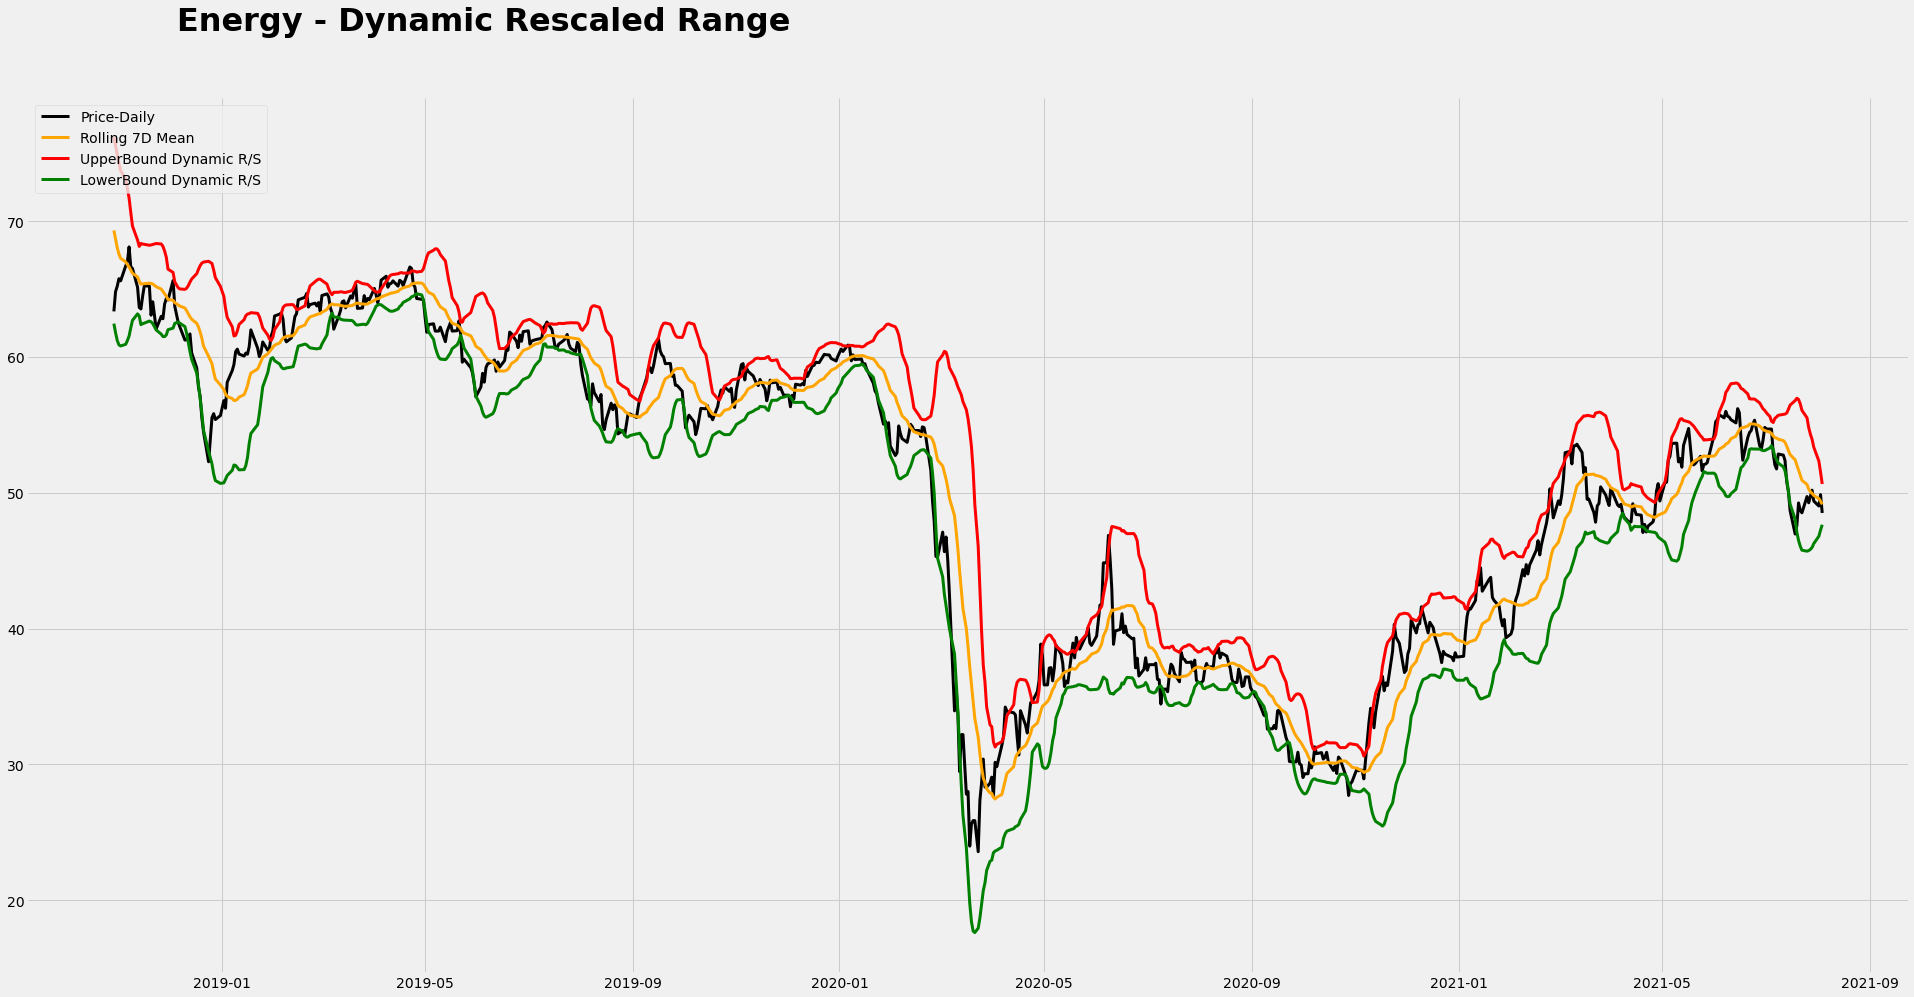

In [19]:
plotLines(energy, 0, 'Energy - Dynamic Rescaled Range', 'ENGYClose', 'rollingMean', 'upperBound', 'lowerBound')

### ISM - Purchasing Managers Index

In [20]:
# ISM-PMI  quandl.get("ISM/MAN_PMI")
ism_pmi = quandl.get("ISm/MAN_PMI", authtoken=quandl.ApiConfig.api_key)
ism_pmi.columns = ['_raw']

ism_pmi = createFeatures(ism_pmi, 'ism')
ism_pmi.tail()

ISM =punctRescaledRange(ism_pmi, 'ism_raw', 12)

In [21]:
ISM.tail()

,ism_raw,ism_%mom,ism_%qoq,ism_%yoy,ism_smoothingMA,ism_rocMA,ism_smoothedRoC,rollingList,rollingMean,meanAdjustedSeries,rescaledRange,std,upperBound,lowerBound
Date,,,,,,,,,,,,,,
2021-03-01,64.7,6.414474,6.942149,30.181087,23.237260,2.555667,1.232538,"[41.7, 43.1, 52.2, 53.7, 55.6, 55.7, 58.8, 57....",55.266667,"[-13.57, -12.17, -3.07, -1.57, 0.33, 0.43, 3.5...","[-13.57, -25.74, -28.81, -30.38, -30.05, -29.6...",9.27,64.536667,45.996667
2021-04-01,60.7,-6.182380,3.407155,45.563549,27.985888,4.748628,3.652147,"[43.1, 52.2, 53.7, 55.6, 55.7, 58.8, 57.7, 60....",56.850000,"[-13.75, -4.65, -3.15, -1.25, -1.15, 1.95, 0.8...","[-13.75, -18.4, -21.55, -22.8, -23.95, -22.0, ...",7.29,64.140000,49.560000
2021-05-01,61.2,0.823723,0.657895,41.995360,34.653687,6.667799,5.708213,"[52.2, 53.7, 55.6, 55.7, 58.8, 57.7, 60.5, 58....",58.358333,"[-6.16, -4.66, -2.76, -2.66, 0.44, -0.66, 2.14...","[-6.16, -10.82, -13.58, -16.24, -15.8, -16.46,...",5.39,63.748333,52.968333
2021-06-01,60.6,-0.980392,-6.336940,16.091954,33.457987,-1.195699,2.736050,"[53.7, 55.6, 55.7, 58.8, 57.7, 60.5, 58.7, 60....",59.058333,"[-5.36, -3.46, -3.36, -0.26, -1.36, 1.44, -0.3...","[-5.36, -8.82, -12.18, -12.44, -13.8, -12.36, ...",4.64,63.698333,54.418333
2021-07-01,59.5,-1.815182,-1.976936,10.800745,28.612902,-4.845085,-3.020392,"[55.6, 55.7, 58.8, 57.7, 60.5, 58.7, 60.8, 64....",59.541667,"[-3.94, -3.84, -0.74, -1.84, 0.96, -0.84, 1.26...","[-3.94, -7.78, -8.52, -10.36, -9.4, -10.24, -8...",3.90,63.441667,55.641667


In [22]:
def plotLines(df, i:int, title, w_name, x_name, y_name, z_name):
# def plotLines(df, i:int, title, x_name, y_name):
# def plotLines(df, i:int, title, w_name, y_name, z_name):
    # Controls amount of data to plot
    df =  df[500:]
    
    w = df[w_name]
    x = df[x_name]
    y = df[y_name]
    z = df[z_name]
    
    # Plot style
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(30,15)) # chart 2:1
    
    # Sets Title of Plot
    ax.set_title(title, fontsize=32, fontweight='bold', x=.242, y=1.07)
    
    # Line plot these columns: column1, column2
    plt.plot(w.index, w, color='black', linewidth=3, label="Price-Daily")
    plt.plot(x.index, x, color='orange', linewidth=3, label="Rolling 7D Mean")
    plt.plot(y.index, y, color='red', linewidth=3, label="UpperBound Dynamic R/S")
    plt.plot(z.index, z, color='green', linewidth=3, label="LowerBound Dynamic R/S")
    
    # Additional plot
#     cpi_head.iloc[-320:]['cpi_%yoy'].plot(color='blue')
    
    # Adds a legened
#     plt.legend(loc="upper left")
    
    # Turn off the spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()

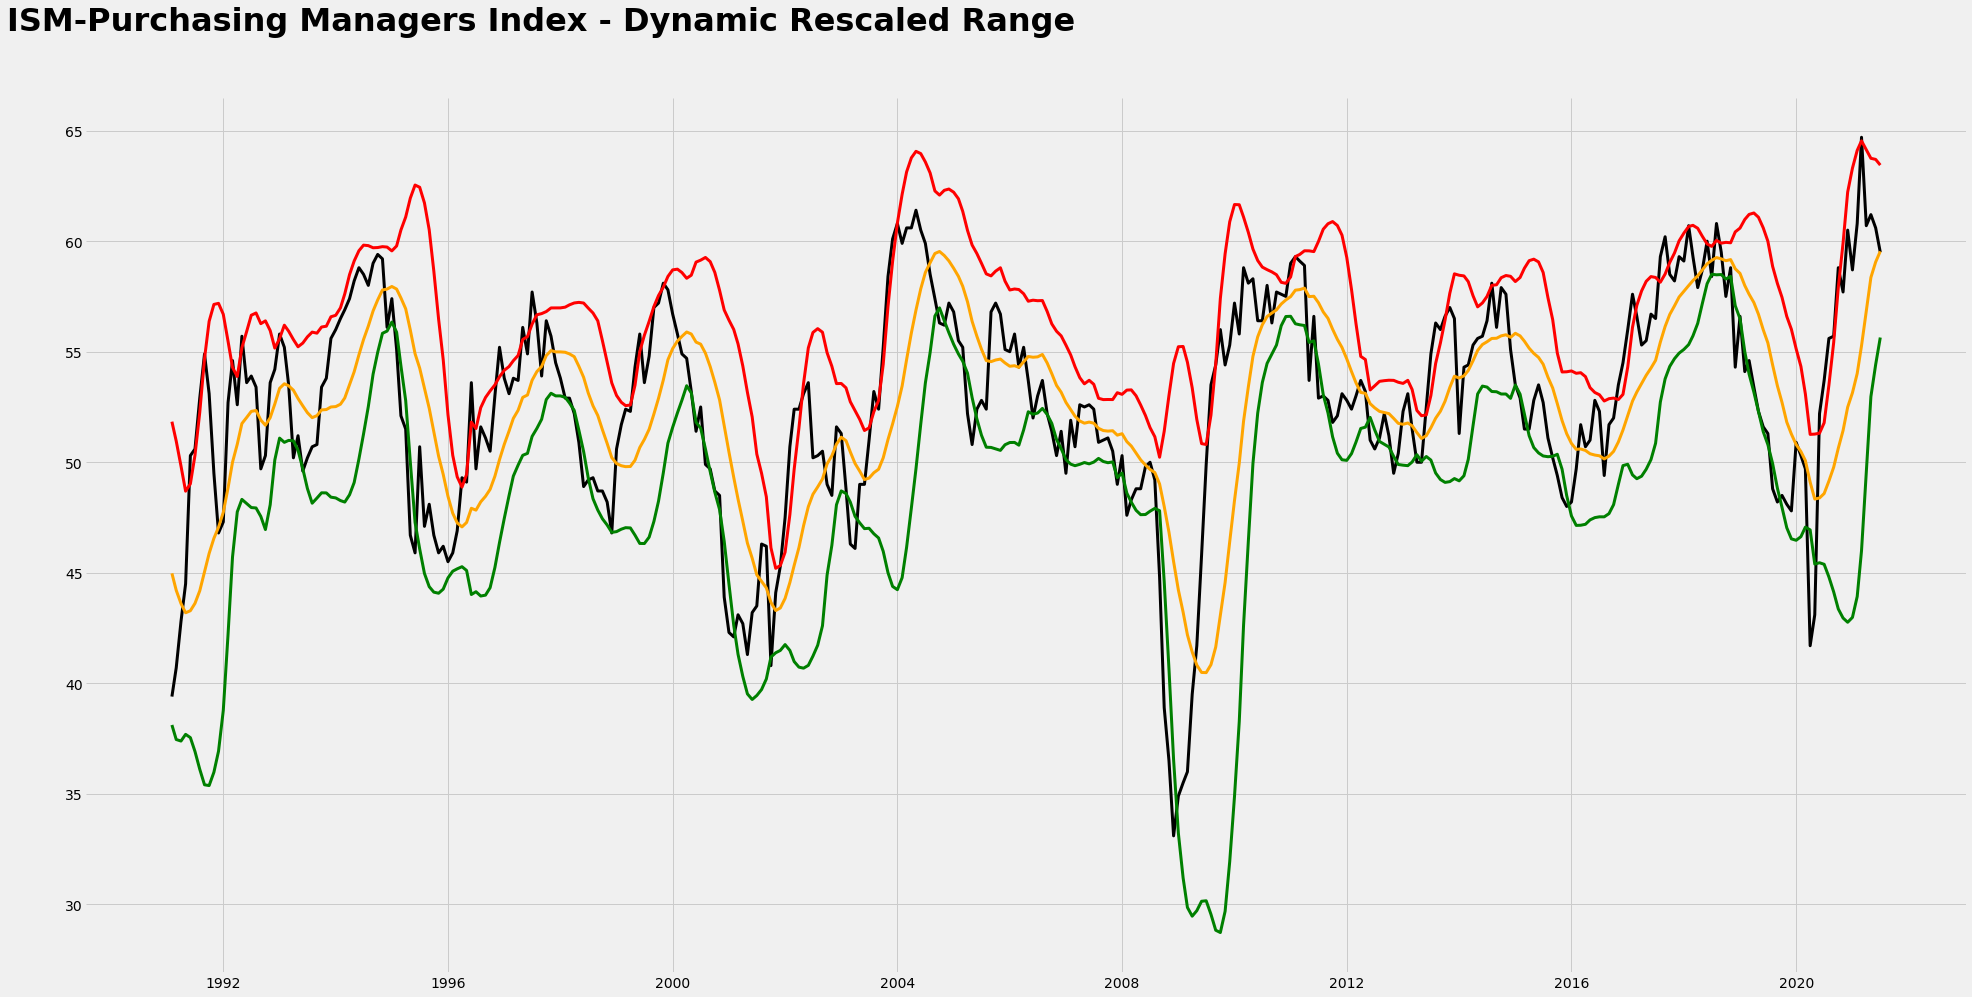

In [23]:
plotLines(ISM, 0, 'ISM-Purchasing Managers Index - Dynamic Rescaled Range', 'ism_raw', 'rollingMean', 'upperBound', 'lowerBound')

In [24]:
# fig, ax = plt.subplots(figsize=(17,5))
# cpi_head.iloc[-300:]['cpi_%yoy'].plot(color='blue');

In [25]:
data_source = 'fred'

start = datetime.datetime (1960, 1, 1)      #  (2005, 5, 1)
end = datetime.datetime (2030, 12, 1)

CPI_Headline = pdr.DataReader('CPIAUCSL', data_source, start, end)
CPI_Headline.index.names = ['Date']
CPI_Headline.columns = ['_']

cpi_head = CPI_Headline.copy()

cpi_head = createFeatures(cpi_head, "cpi")

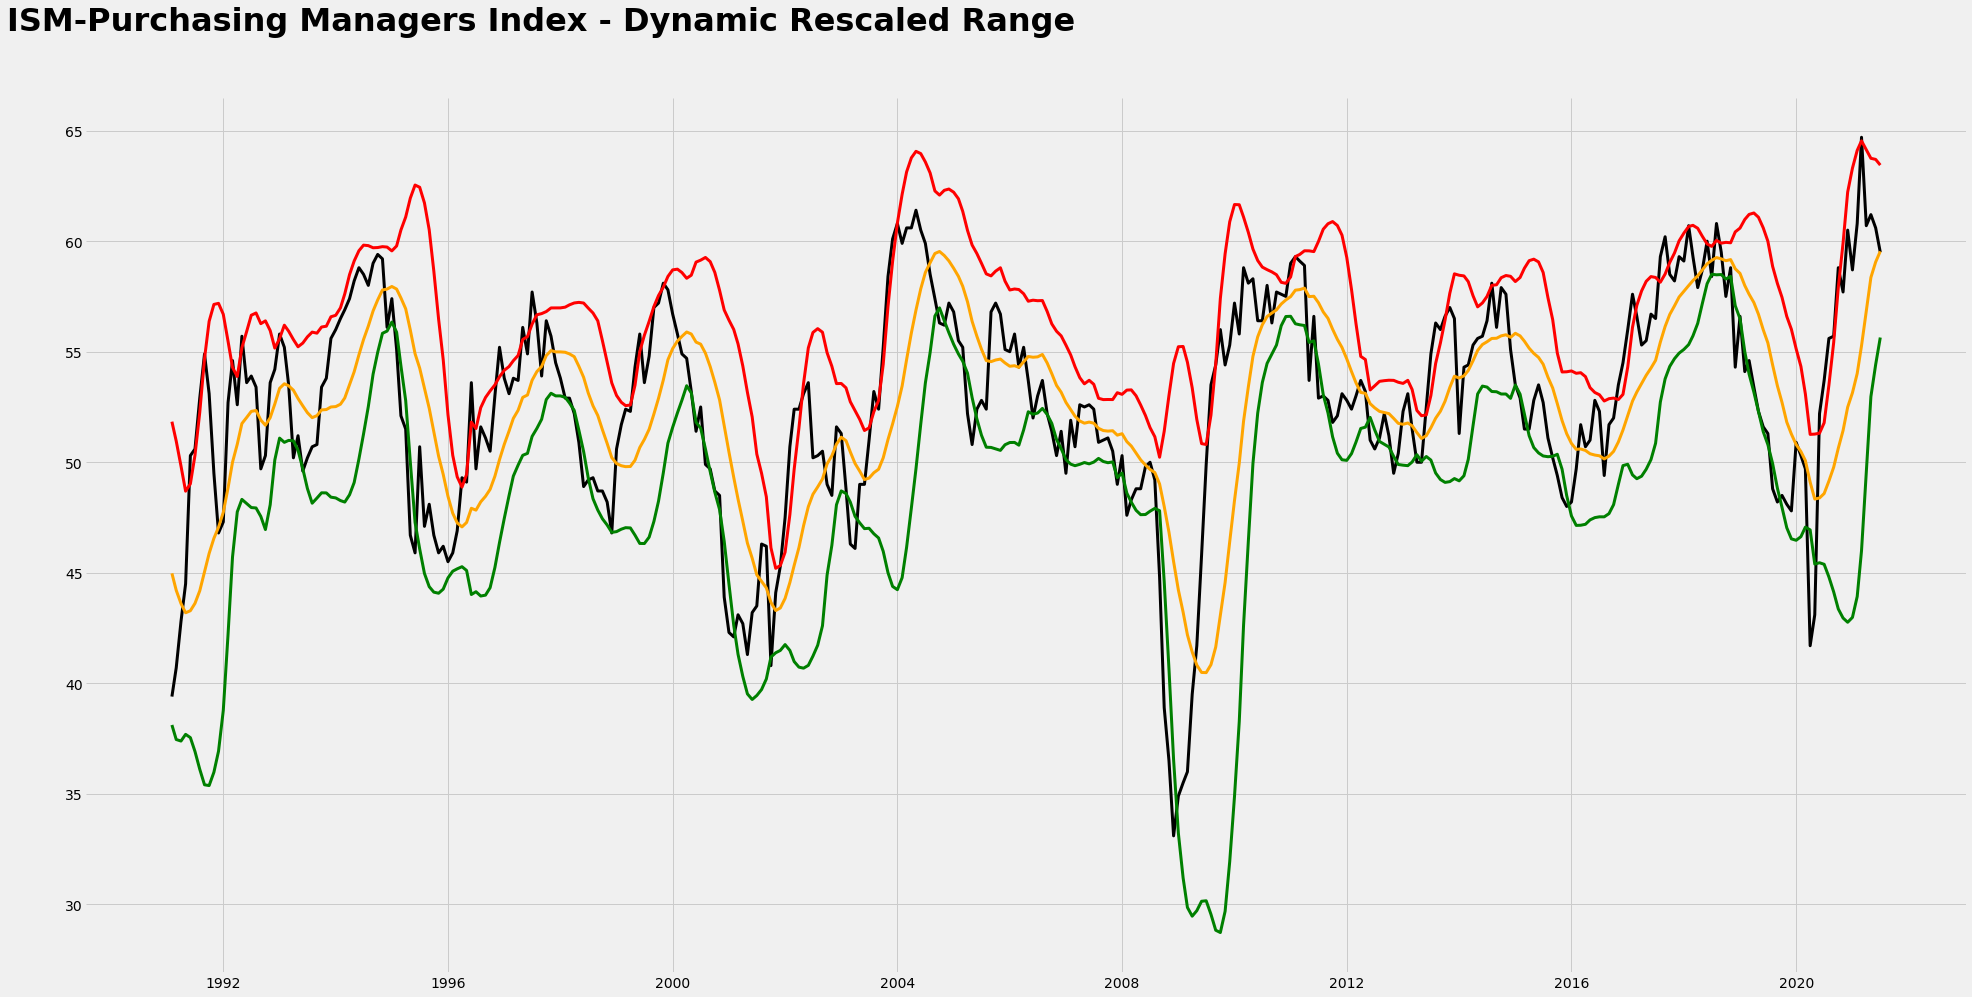

In [26]:
plotLines(ISM, 0, 'ISM-Purchasing Managers Index - Dynamic Rescaled Range', 'ism_raw', 'rollingMean', 'upperBound', 'lowerBound')

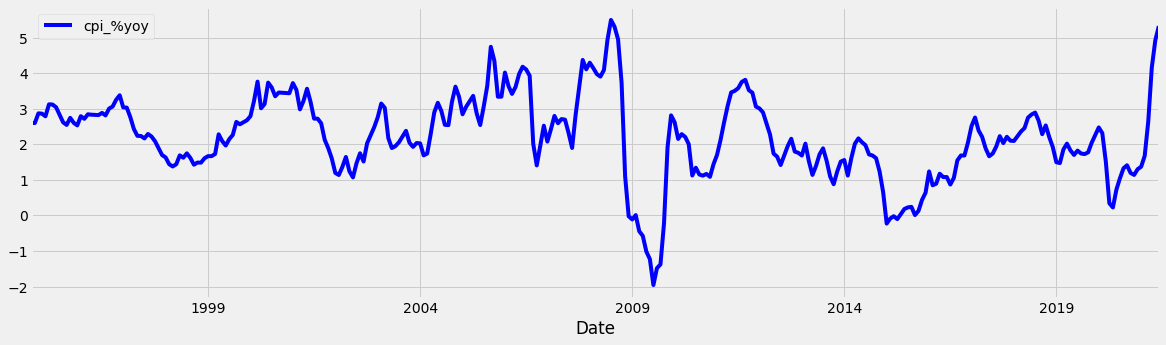

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18,5))
cpi_head.iloc[-320:]['cpi_%yoy'].plot(color='blue')

# cpi_head.iloc[-70:]['cpi_%yoy'].plot(color='blue')
# cpi_head.iloc[-70:]['cpi_ma3yoy%'].plot(color='orange')
plt.legend(loc="upper left");

In [28]:
scaledPMI['rollingList'] = [window.to_list() for window in scaledPMI['PMI_raw'].rolling(window=8)]


window=3


scaledPMI['rollingMean'] = scaledPMI['PMI_raw'].rolling(window=window).mean()
scaledPMI['rollingMean'] = scaledPMI['rollingMean']


all = []

zipped = zip(scaledPMI['rollingList'], scaledPMI['rollingMean'])

for x, y in zipped:
    all.append([round(x[i]-y, 2) for i in range(len(x))])


scaledPMI['meanAdjustedSeries'] = all

NameError: name 'scaledPMI' is not defined

In [ ]:
scaledPMI = scaledPMI[7:]
scaledPMI.reset_index(inplace=True)
scaledPMI.drop(['index'], axis=1, inplace=True)
# scaledPMI.head(10)

In [ ]:
scaledPMI.tail(10)
x = np.array(scaledPMI['meanAdjustedSeries'])
ls = []

for item in x:
    ls.append(np.cumsum(item).round(2))
# std = ls   
    
scaledPMI['rescaledRange'] = ls

ls1 = []
x1 = np.array(scaledPMI['rescaledRange'])
for item in x1:
    ls1.append(np.std(item).round(2))

scaledPMI['std'] = ls1


scaledPMI['upper'] = scaledPMI['rollingMean'] + scaledPMI['std'] 
scaledPMI['lower'] = scaledPMI['rollingMean'] - scaledPMI['std'] 
scaledPMI.tail(10)

In [ ]:
scaledPMI.head()

In [ ]:
scaledPMI['upper'] = scaledPMI['rollingMean'] + scaledPMI['std'] 
scaledPMI['lower'] = scaledPMI['rollingMean'] - scaledPMI['std'] 
scaledPMI.tail(10)

In [ ]:
scaledPMI.columns

In [ ]:
plotLines(scaledPMI, 500, 'scaledPMI (StandardScaler)', 'PMI_raw', 'rollingMean', 'upper', 'lower')

In [ ]:
# plotLines(scaledPMI, 750, 'scaledPMI (StandardScaler)', 'PMI_%yoy', 'PMI_rocMA')

In [ ]:
# import numpy as np
# import math
import statistics as stats
# TODO: Rescaled Range
#  using 8 consecutive periods  apply df.rolling(8).sum()

ls = [2, 4, 6, 12, 13, 8, 5, 6]
mean = sum(ls)/ len(ls)
result = [i - average_ls for i in ls]
result
res = stats.pstdev(result)
res


# scalePMI.tail()
                                    
# def subMean_from_list(df):
#     result = [i - average_ls for i in ls]
#     df['subMean_list'] = sum(df) / len(df)
#     df['_%yoy'] = df.iloc[:,0].pct_change(12) * 100
    
#     df['_smoothingMA'] = (df['_%yoy'] + df['_%yoy'].shift(1) + df['_%yoy'].shift(2) + df['_%yoy'].shift(3)) / 4
#     df['_rocMA'] = roc(df['_smoothingMA'], 1)
#     df['_smoothedRoC'] = smoothingMA2(df['_rocMA'])
    
#     df = df.add_prefix(prefix)
#     df.dropna(inplace=True)

#     return df['subMean_list']

# test = subMean_from_list(scaledPMI['rollingList'])
# test.tail()
# def rescaled_range(df, window):
#     nums_in_window = []
#     rolling_mean = df[0].rolling(windwow).mean()
#     rolling_std = rolling_mean.rolling(window).std()

#     df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
#     df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)     

# bollinger_strat(data,20,2)

In [ ]:
# TODO: Make histograms and show nonlinear relationship

### Durable Goods

In [ ]:
DurGoods = createFeatures(DurableGoods, "DurGoods")

scaled_DurGoods = standardScaler(DurGoods, "scaled_DurGoods")

# DurGoods.head()
scaled_DurGoods.head()

### GDP

In [ ]:
# GDP Seasonally Adjusted annual rate
GDP = pdr.DataReader('GDPC1', data_source, start, end)
# GDP.index = GDP.index.strftime('%Y-%m')
# GDP.index = pd.PeriodIndex(GDP.index, freq='Q')
GDP.columns = ['GDP']
GDP.index.names = ['Date']

GDP['GDP%yoy'] = GDP['GDP'].pct_change(4) * 100
GDP['GDP_roc'] = RoC(GDP['GDP'], 3)
GDP = GDP.round(2)

In [ ]:
st_ismPMI.columns

In [ ]:
# # Used a smaller dataset in order to visualize the chart better
# st_ismPMIsmall = st_ismPMI[700:]

# # Plotting the StandardScaled DataFrame
# plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize=(30,15))  # chart 3:1

# ax.set_title("ISM-PMI (applied StandardScaler)", 
#              fontsize=22, fontweight='bold', x=.242, y=1.07)

# plt.plot(st_ismPMIsmall.index, st_ismPMIsmall['PMI_%yoy'], color='black', linewidth=3)
# # plt.plot(st_ismPMIsmall.index, st_ismPMIsmall['PMI_%mom'], color='black', linewidth=3)
# plt.plot(st_ismPMIsmall.index, st_ismPMIsmall['smoothed_roc'], color='green', linewidth=3)
# plt.plot(st_ismPMIsmall.index, st_ismPMIsmall['roc_MA'], color='red', linewidth=1)

# # plt.plot(ism_pmi.index, ism_pmi['PMI_%yoy_scaled'], color='orange', linewidth=3)

# # Turn off the spines
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# plt.show()

In [ ]:
# Pulling Durable Goods data from FRED
# Reading in the dataset - Durable Goods - creating new features
DurableGoods = pdr.DataReader('DGORDER', data_source, start, end)
DurableGoods.index.names = ['Date']
DurableGoods.columns = ['DurGoods']

DurableGoods['DurGoods_%mom'] = DurableGoods['DurGoods'].pct_change() * 100
DurableGoods['DurGoods_%yoy'] = DurableGoods['DurGoods'].pct_change(12) * 100
DurableGoods['DurGoods_smoothingMA'] = (DurableGoods['DurGoods_%yoy'] + DurableGoods['DurGoods_%yoy'].shift(1)) / 2

DurableGoods['DurGoods_rocMA'] = roc(DurableGoods['DurGoods_smoothingMA'], 1)
DurableGoods['DurGoods_smoothedRoC'] = smoothingMA2(DurableGoods['DurGoods_rocMA'])

DurableGoods.dropna(inplace=True)
#  Scaling the dataset - Durable Goods
scaler_st = StandardScaler()
scaler_mm = MinMaxScaler(feature_range=(-1,1))

st_DurableGoods = scaler_st.fit_transform(DurableGoods)
mm_DurableGoods = scaler_mm.fit_transform(DurableGoods)
st_DurableGoods = pd.DataFrame(st_PMI, columns=DurableGoods.columns)
mm_DurableGoods = pd.DataFrame(mm_PMI, columns=DurableGoods.columns)
st_DurableGoods.dropna(inplace=True)
mm_DurableGoods.dropna(inplace=True)

mm_DurableGoods.reset_index(inplace=True)
mm_DurableGoods.drop(['index'], axis=1, inplace=True)
st_DurableGoods.reset_index(inplace=True)
st_DurableGoods.drop(['index'], axis=1, inplace=True)

In [ ]:
print(DurableGoods.shape)
print(st_DurableGoods.shape)
st_DurableGoods.head()

In [ ]:
plotLines(st_DurableGoods, 750, 'Durable Goods (StandardScaler)', 'DurGoods_%yoy', 'DurGoods_rocMA', 'DurGoods_smoothedRoC')

In [ ]:
# Industrial Production - IPMAN quandl.get("FRED/IPMAN")
ind_pro = quandl.get("FRED/IPMAN", authtoken=quandl.ApiConfig.api_key)
ind_pro.columns = ['Ind_Pro']

ind_pro['IndPro_%mom'] = ind_pro['Ind_Pro'].pct_change() * 100
ind_pro['IndPro_%yoy'] = ind_pro['Ind_Pro'].pct_change(12) * 100

ind_pro['IndPro_smoothingMA'] = (ind_pro['IndPro_%yoy'] + ind_pro['IndPro_%yoy'].shift(1)) / 2

ind_pro['IndPro_rocMA'] = roc(ind_pro['IndPro_smoothingMA'], 1)
ind_pro['IndPro_smoothed_roc'] = smoothingMA2(ind_pro['IndPro_rocMA']) 
ind_pro.dropna(inplace=True)

scaler_st = StandardScaler()
scaler_mm = MinMaxScaler(feature_range=(-1,1))

st_ind_pro = scaler_st.fit_transform(ind_pro)
mm_ind_pro = scaler_mm.fit_transform(ind_pro)
st_ind_pro = pd.DataFrame(st_ind_pro, columns=ind_pro.columns)
mm_ind_pro = pd.DataFrame(mm_ind_pro, columns=ind_pro.columns)

st_ind_pro.dropna(inplace=True)
mm_ind_pro.dropna(inplace=True)

mm_ind_pro.reset_index(inplace=True)
mm_ind_pro.drop(['index'], axis=1, inplace=True)
st_ind_pro.reset_index(inplace=True)
st_ind_pro.drop(['index'], axis=1, inplace=True)

In [ ]:
print(ind_pro.shape)
st_ind_pro.head()
help(plotLines)

In [ ]:
plotLines(st_ind_pro, 400, 'Industrial Production (applied Standard Scaler)', 'IndPro_%yoy', 'IndPro_rocMA', 'IndPro_smoothed_roc')

In [ ]:
# Advance Retail Sales: Retail and Food Services, Total (RSAFS)
RetailSales = pdr.DataReader('RSAFS', data_source, start, end)
RetailSales.index.names = ['Date']
RetailSales.columns = ['RetailSales']

# RetailSales.index = RetailSales.index.strftime('%Y-%m')
# RetailSales.index = pd.PeriodIndex(RetailSales.index, freq='Q')

RetailSales['RetailSales%qoq'] = RetailSales['RetailSales'].pct_change() * 100
RetailSales['RetailSales%yoy'] = RetailSales['RetailSales'].pct_change(12) * 100
RetailSales['RetailSales_roc'] = roc(RetailSales['RetailSales'], 11)
RetailSales['RetailSales_roc%yoy'] = RetailSales['RetailSales%yoy'].diff().round(2)

In [ ]:
# help(plotLines)